In [2]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, choose_gauge_fixing_biased, choose_guage_fixing_asym, random_pauli, random_pauli_asym, print_pauli_error, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2


## Testing by Decoders
1. MWPM
2. BP+OSD
3. BP-Matching

## MWPM - Uniform Noise

In [5]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:54<00:00, 29.16s/it]


In [6]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

In [ ]:
with open('data/phys_vs_log_err_rate_long_surface_code_mwpm_1', 'rb') as fp:
    surface_code_logical_error_probs = pickle.load(fp)

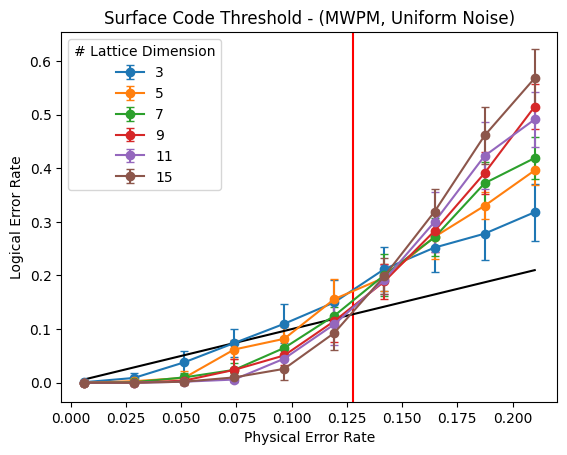

In [9]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Uniform Noise)')
plt.axvline(0.128, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [24]:
# DS Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:58<00:00, 39.83s/it]


In [25]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

In [217]:
with open('data/phys_vs_log_err_rate_long_compass_code_mwpm_1', 'rb') as fp:
    compass_code_logical_error_probs = pickle.load(fp)

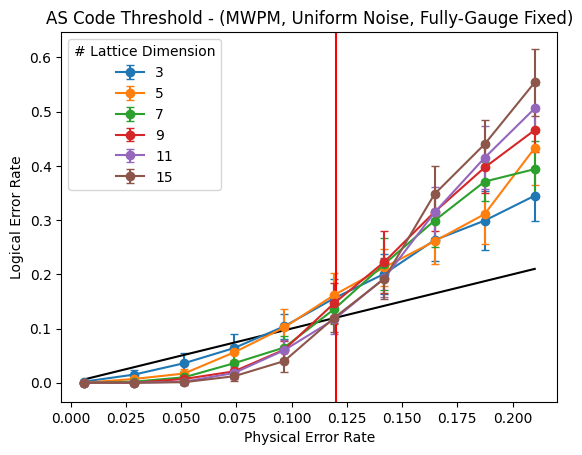

In [218]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('AS Code Threshold - (MWPM, Uniform Noise, Fully-Gauge Fixed)')
plt.axvline(0.12, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [206]:
# BS Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        # coloring = np.zeros(((dim - 1)**2,))
        # locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        # for loc in locs:
        #     coloring[loc] = np.random.choice([-1,1])
        # lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:42<00:00,  7.15s/it]


In [207]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_long_bs_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

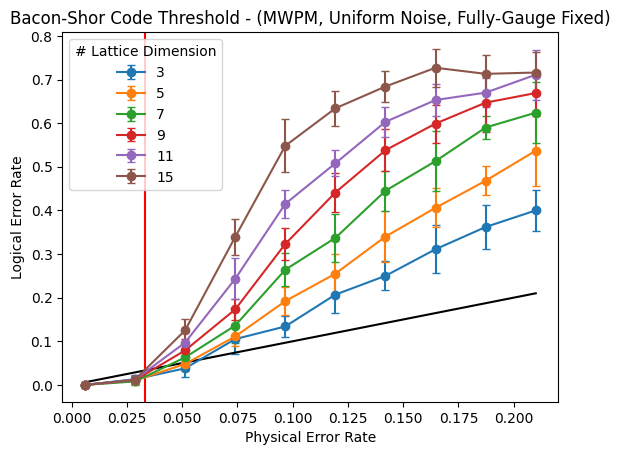

In [214]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Bacon-Shor Code Threshold - (MWPM, Uniform Noise, Fully-Gauge Fixed)')
plt.axvline(0.033, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## BP+OSD - Uniform Noise

In [15]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
bootstrapped_runs = 10
num_errors = 100 
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 5
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 5
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

100%|██████████| 6/6 [04:21<00:00, 43.55s/it]


In [16]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

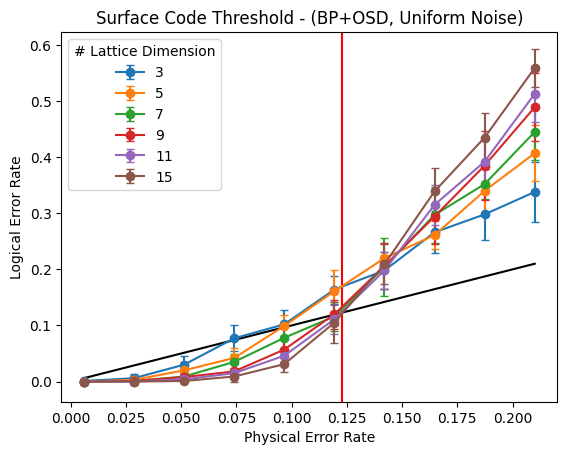

In [22]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Uniform Noise)')
plt.axvline(0.123, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [25]:
# AS Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
bootstrapped_runs = 10
num_errors = 100 
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [04:43<00:00, 47.18s/it]


In [26]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

In [219]:
with open('data/phys_vs_log_err_rate_compass_code_bposd_1', 'rb') as fp:
    compass_code_logical_error_probs = pickle.load(fp)

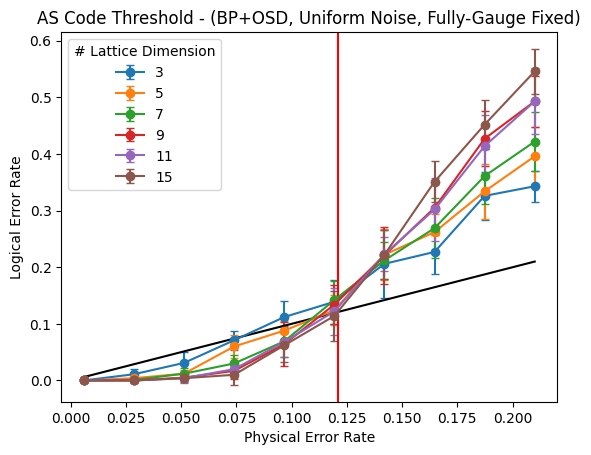

In [220]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('AS Code Threshold - (BP+OSD, Uniform Noise, Fully-Gauge Fixed)')
plt.axvline(0.121, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## BP-Matching - Uniform Noise

In [30]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10 
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = compass_to_surface(dim,dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

100%|██████████| 6/6 [06:07<00:00, 61.26s/it] 


In [31]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_bpmatching_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

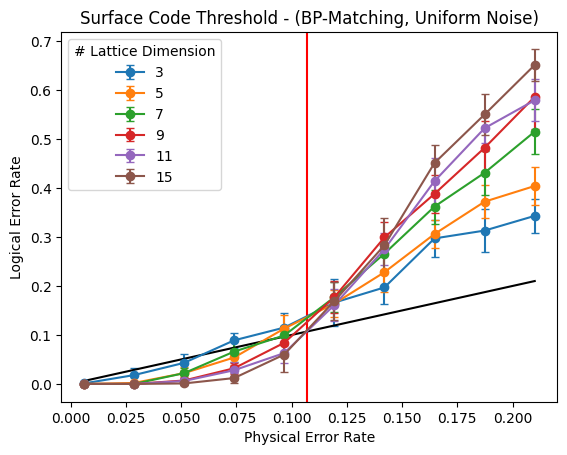

In [35]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP-Matching, Uniform Noise)')
plt.axvline(0.107, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [36]:
# AS Simulation
dims = [3,5,7,9,11,15]
num_faces_colored = [dim**2 for dim in dims]
num_guage_fixings = 10 
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_guage_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

100%|██████████| 6/6 [06:31<00:00, 65.26s/it] 


In [37]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_compass_code_bpmatching_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

In [221]:
with open('data/phys_vs_log_err_rate_compass_code_bpmatching_1', 'rb') as fp:
    compass_code_logical_error_probs = pickle.load(fp)

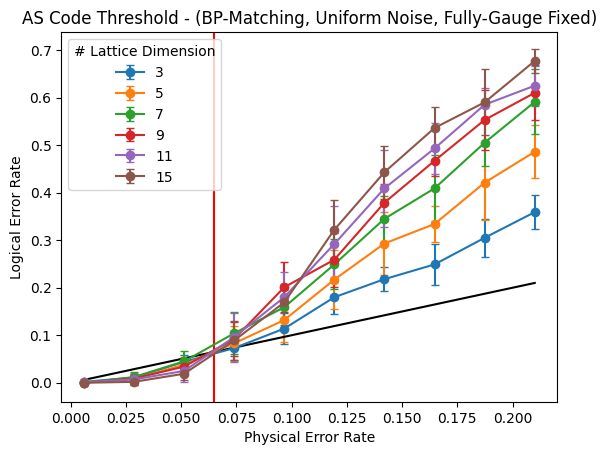

In [222]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('AS Code Threshold - (BP-Matching, Uniform Noise, Fully-Gauge Fixed)')
plt.axvline(0.065, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## MWPM - Biased X Pauli Noise

In [42]:
# Test of coloring function
lat = Lattice2D(6,6)
lat = choose_gauge_fixing_biased(lat, 'X', 0.08, 0.1)
print(lat)

000---001---002---003---004---005
 |  ░  |  ▓  |  ░  |  ░  |  ░  |
006---007---008---009---010---011
 |  ░  |  ░  |  ░  |  ▓  |  ░  |
012---013---014---015---016---017
 |  ░  |  ░  |  ░  |  ░  |  ▓  |
018---019---020---021---022---023
 |  ░  |  ▓  |  ░  |  ░  |  ░  |
024---025---026---027---028---029
 |  ░  |  ░  |  ▓  |  ░  |  ▓  |
030---031---032---033---034---035



In [28]:
# Surface Code Simulation
# Biased towards X errors

dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.13, 10)
num_errors = 100 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}
all_rates = []

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

100%|██████████| 6/6 [03:14<00:00, 32.35s/it]


In [29]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

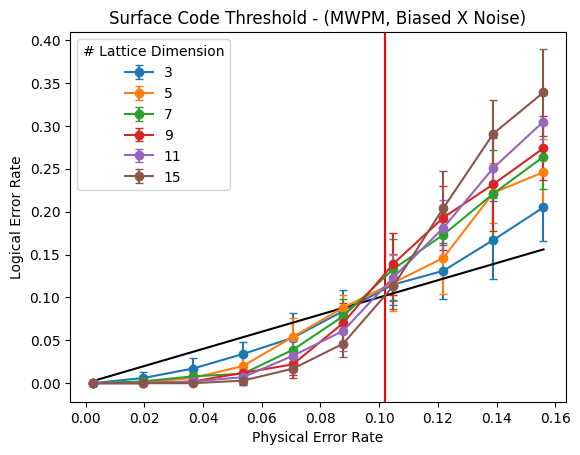

In [34]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Biased X Noise)')
plt.axvline(0.102, color='red')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [45]:
# DS Code Simulation
# Biased X Error
dims = [3,5,7,9,11,15]
phys_err_rates_range =  np.linspace(0.002, 0.25, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            lat = choose_gauge_fixing_biased(lat, 'X', rates[0], np.sum(rates))
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1
total_phys_err_rates_range = [np.sum([r, r * 0.1, r * 0.1]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [08:16<00:00, 82.71s/it] 


In [46]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

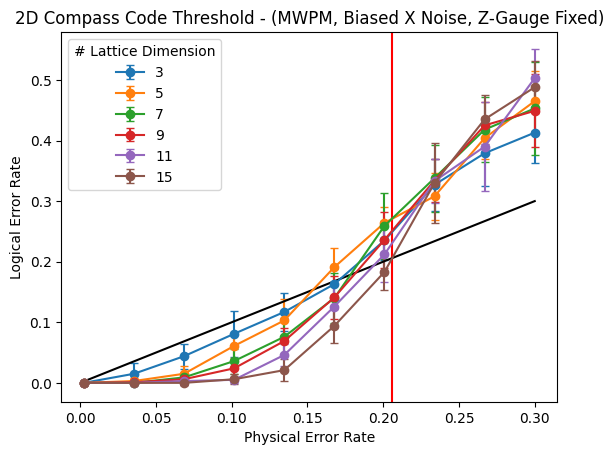

In [51]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.axvline(0.206, color='red')
plt.title('2D Compass Code Threshold - (MWPM, Biased X Noise, Z-Gauge Fixed)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## BP+OSD - Biased X Noise

In [82]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.25, 10)
bootstrapped_runs = 10
num_errors = 100 
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            error_probability = np.sum(rates)
            err_prob_x = rates[0] + rates[1]
            err_prob_z = rates[1] + rates[2]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = err_prob_x,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 5
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = err_prob_z, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 5
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:15<00:00, 32.60s/it]


In [83]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

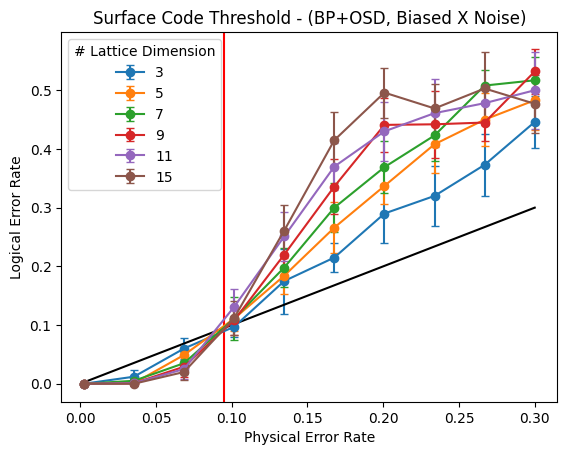

In [86]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Biased X Noise)')
plt.axvline(0.095, color='red')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [90]:
# AS Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.25, 10)
bootstrapped_runs = 10
num_errors = 100 
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = Lattice2D(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            lat = choose_gauge_fixing_biased(lat, 'X', rates[0], np.sum(rates))
            error_probability = np.sum(rates)
            err_prob_x = rates[0] + rates[1]
            err_prob_z = rates[1] + rates[2]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = err_prob_x,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = err_prob_z, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [06:45<00:00, 67.52s/it] 


In [91]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

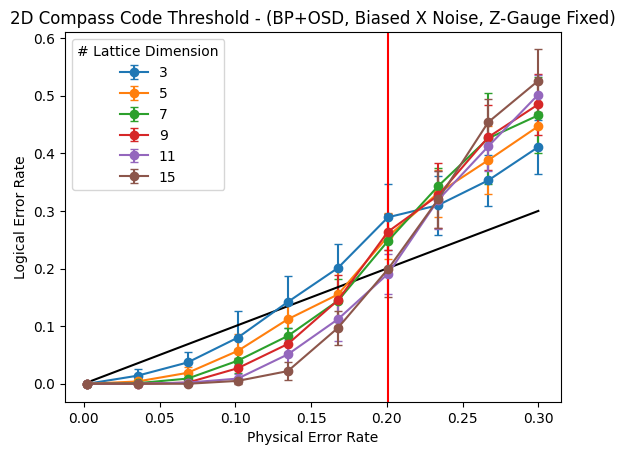

In [94]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.axvline(0.201, color='red')
plt.title('2D Compass Code Threshold - (BP+OSD, Biased X Noise, Z-Gauge Fixed)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## BP-Matching - Biased X Noise

In [126]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10 
phys_err_rates_range = np.linspace(0.002, 0.25, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = compass_to_surface(dim,dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            err_prob_x = rates[0] + rates[1]
            err_prob_z = rates[1] + rates[2]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = err_prob_x,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = err_prob_z, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsZ)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsX)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:58<00:00, 39.83s/it]


In [127]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_surface_code_bpmatching_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

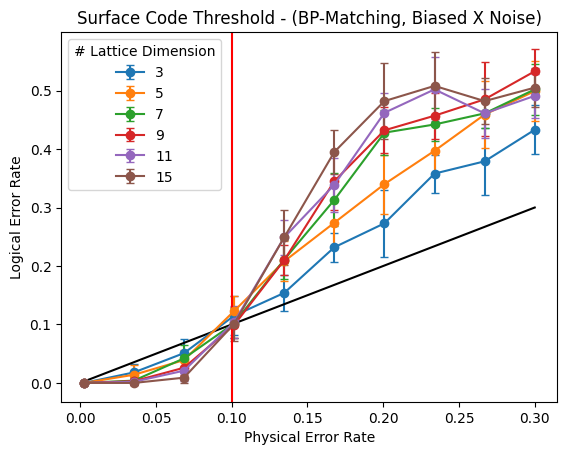

In [135]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP-Matching, Biased X Noise)')
plt.axvline(0.1, color='red')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [129]:
# AS Code Simulation
dims = [3,5,7,9,11,15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10 
phys_err_rates_range = np.linspace(0.002, 0.25, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim,dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1]
            lat = choose_gauge_fixing_biased(lat, 'X', rates[0], np.sum(rates))
            err_prob_x = rates[0] + rates[1]
            err_prob_z = rates[1] + rates[2]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = err_prob_x,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = err_prob_z, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsZ)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsX)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1
total_phys_err_rates_range = [np.sum([r * 0.1, r * 0.1, r]) for r in phys_err_rates_range]

100%|██████████| 6/6 [08:23<00:00, 83.86s/it] 


In [130]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_biased_compass_code_bpmatching_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

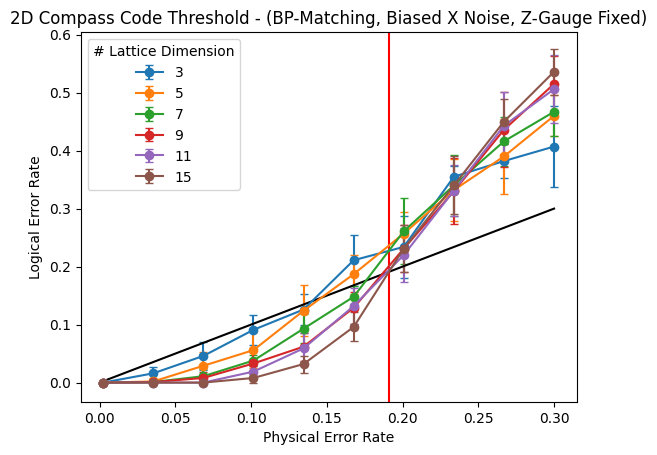

In [134]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.axvline(0.191, color='red')
plt.title('2D Compass Code Threshold - (BP-Matching, Biased X Noise, Z-Gauge Fixed)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## MWPM - Spatially Asymmetric Noise

In [194]:
lat = Lattice2D(10,10)
rates = [0.02,0.02,0.02]
e = random_pauli_asym(10,10,rates,(-1,1))
print_pauli_error(e, 10, 10)

Z | Z | X | X | Z | _ | _ | X | _ | _
Z | Y | Z | X | Y | _ | _ | _ | _ | _
X | Z | Y | Z | Y | _ | _ | _ | _ | _
X | X | Z | Y | Z | _ | _ | _ | _ | _
Z | Z | X | Z | Y | _ | Z | _ | _ | _
_ | _ | _ | _ | _ | Y | _ | _ | _ | _
_ | _ | _ | X | _ | _ | _ | _ | _ | _
_ | _ | Z | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | _ | _ | _ | _ | _
_ | _ | _ | _ | _ | X | _ | _ | _ | _


In [195]:
# Surface Code Simulation
# Asymmetric noise

dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.07, 10)
num_errors = 200 
bootstrapped_runs = 10
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}
all_rates = []

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                while E == 'I' * lat.size():
                    E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ err_prob_x, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1
total_phys_err_rates_range = [np.sum([r, r, r]) for r in phys_err_rates_range]

100%|██████████| 6/6 [05:49<00:00, 58.31s/it]


In [196]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_asym_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

In [181]:
with open('data/phys_vs_log_err_rate_asym_surface_code_mwpm_1', 'rb') as fp:
    surface_code_logical_error_probs = pickle.load(fp)

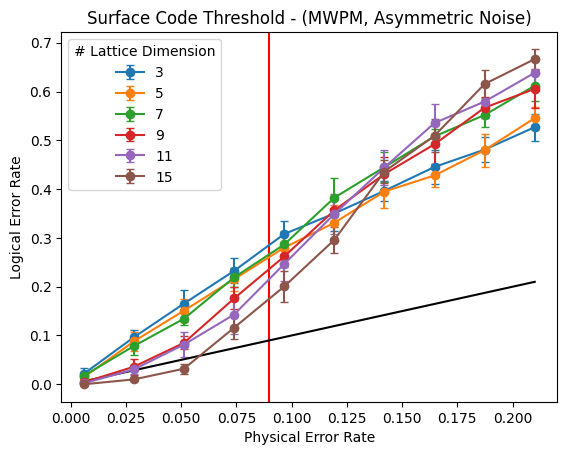

In [197]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Asymmetric Noise)')
plt.axvline(0.09, color='red')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [198]:
lat = Lattice2D(10,10)
lat = choose_guage_fixing_asym(lat, (1,1))
print(lat)

000---001---002---003---004---005---006---007---008---009
 |  ▓  |  ▓  |  ▓  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |  ░  |
010---011---012---013---014---015---016---017---018---019
 |  ▓  |  ▓  |  ░  |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |
020---021---022---023---024---025---026---027---028---029
 |  ░  |  ▓  |  ▓  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |  ░  |
030---031---032---033---034---035---036---037---038---039
 |  ▓  |  ▓  |  ░  |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |
040---041---042---043---044---045---046---047---048---049
 |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |  ░  |
050---051---052---053---054---055---056---057---058---059
 |  ░  |  ░  |  ░  |  ▓  |  ░  |  ▓  |  ▓  |  ░  |  ▓  |
060---061---062---063---064---065---066---067---068---069
 |  ░  |  ▓  |  ░  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |
070---071---072---073---074---075---076---077---078---079
 |  ▓  |  ▓  |  ░  |  ▓  |  ░  |  ▓  |  ░  |  ░  |  ▓  |
080---081---082---083---084---085---086---087---088---089
 |  ▓  |  ▓  |  ▓  |  

In [199]:
# DS Code Simulation
# Asym Error
dims = [3,5,7,9,11,15]
phys_err_rates_range =  np.linspace(0.002, 0.07, 10)
num_errors = 200 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            lat = choose_guage_fixing_asym(lat, (-1,1))
            for err in range(num_errors):
                E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                while E == 'I' * lat.size():
                    E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1
total_phys_err_rates_range = [np.sum([r, r, r]) for r in phys_err_rates_range]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [10:07<00:00, 101.20s/it]


In [200]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_asym_compass_code_mwpm_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)

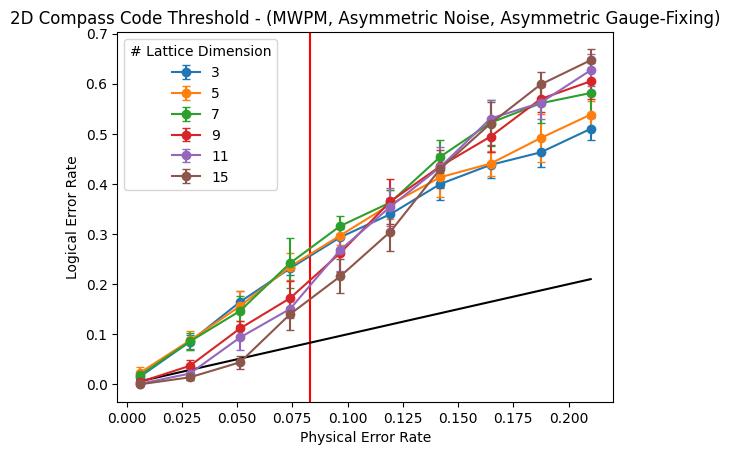

In [201]:
for dim in compass_code_logical_error_probs.keys():
    compass_code_logical_error_list = np.array(compass_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(compass_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(compass_code_logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.axvline(0.083, color='red')
plt.title('2D Compass Code Threshold - (MWPM, Asymmetric Noise, Asymmetric Gauge-Fixing)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## BP-OSD Spatially Asymmetric Noise

In [202]:
# Surface Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.2, 10)
bootstrapped_runs = 10
num_errors = 100 
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for num_error in range(num_errors):
                E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                while E == 'I' * lat.size():
                    E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                error = pauli2vector(E)
                error_prob_x = np.sum(rates) * pauli2vector(E)[:len(pauli2vector(E))//2]
                error_prob_z = np.sum(rates) * pauli2vector(E)[len(pauli2vector(E))//2:]
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = None,
                    channel_probs = error_prob_x,
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 5
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = None, 
                    channel_probs = error_prob_z, 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 5
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [04:12<00:00, 42.06s/it]


In [203]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_asym_surface_code_bposd_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

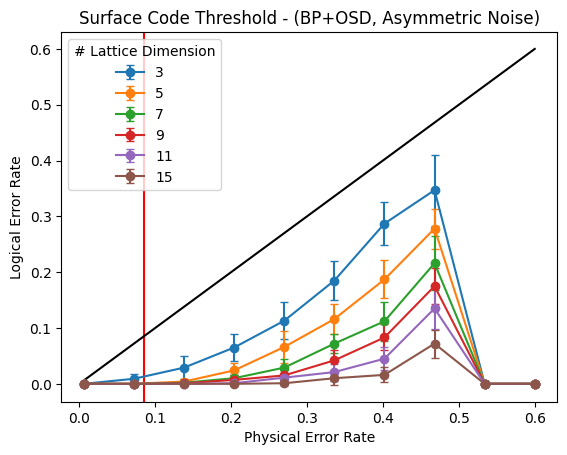

In [204]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), fmt='o-', capsize=3)

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+OSD, Asymmetric Noise)')
plt.axvline(0.085, color="red")
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

In [ ]:
# AS Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.002, 0.2, 10)
bootstrapped_runs = 10
num_errors = 100 
logical_errors = {dim: np.zeros((bootstrapped_runs, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = Lattice2D(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            lat = choose_guage_fixing_asym(lat, (-1,1))
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                while E == 'I' * lat.size():
                    E = random_pauli_asym(lat.dimX, lat.dimZ, rates, (-1,1))
                error = pauli2vector(E)
                error_prob_x = np.sum(rates) * pauli2vector(E)[:len(pauli2vector(E))//2]
                error_prob_z = np.sum(rates) * pauli2vector(E)[len(pauli2vector(E))//2:]
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = None,
                    channel_probs = error_prob_x,
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = None, 
                    channel_probs = error_prob_z, 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

In [ ]:
compass_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        compass_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_asym_compass_code_bposd_1', 'wb') as fp:
    pickle.dump(compass_code_logical_error_probs, fp)